In [1]:
from comet_ml import Experiment
experiment = Experiment(project_name="simple model")
import glob, os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
sys.path.append("..")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/bamasa/simple-model/1c6caa0b06cb4023986a4e2ce840ab13



In [2]:
import numpy as np
from env import SimpleModel, GeneralSimpleModel
from wrappers import ImpactWrapper
from agents import AgentCE
from train import cem
from utils import mse, mspe
import torch
import pickle
import pylab

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
%matplotlib inline

In [3]:
torch.manual_seed(123)
np.random.seed(123)

### Env

In [4]:
# true system params
big_b=1
big_omega=1
theta=0
m=1
k=0.1
beta=0.02
big_f_0=1
t_min=0
t_max=10

t0 = 0
t_step = 1
n_steps = 20
n_prev = 3

delta = beta / (2 * m)
omega_0 = k / m

impact_amplitude = 1
damping_ratio = 0.05

metric="mspe"

In [5]:
def x_impact(t, a=impact_amplitude, b=damping_ratio):
#     if t < 0:
#         return 1
    return a * np.exp(-t * b)

def x_pendulum(t, big_b, big_omega, theta):
    return big_b * np.cos(big_omega * t - theta)

def generate_history(t0, step, n_steps, big_b=big_b, big_omega=big_omega, theta=theta,
                     impact=x_impact, x_pendulum=x_pendulum):
    res = []
    for _ in range(n_steps):
        res.append(
            x_pendulum(t0, big_b, big_omega, theta) * impact(t0)
        )
        t0 += step
    return res

In [6]:
history = generate_history(t0, t_step, n_steps)

# plt.title("x history")
# plt.xlabel("t")
# plt.ylabel("x")
# plt.grid(True)
# plt.plot(history)
# plt.show()

In [11]:
def create_env(env_model, x_impact, impact_amplitude, damping_ratio):
    impact = lambda t: x_impact(t, impact_amplitude, damping_ratio)
    history = generate_history(t0=t0, step=t_step, n_steps=n_steps, impact=impact)
    env = env_model(history=history, t0=t0, t_step=t_step,n_steps=n_steps, 
                    big_f_0=big_f_0, k=k, n_prev=n_prev, metric=metric)
    env = ImpactWrapper(env, impact, param1=impact_amplitude, param2=damping_ratio)
    return env

In [12]:
test_env_DC_RL = create_env(SimpleModel, x_impact, impact_amplitude, damping_ratio)
test_env_just_RL = create_env(GeneralSimpleModel, x_impact, impact_amplitude, damping_ratio)

# Agents

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

agent_DC_RL = AgentCE(test_env_DC_RL, h_size=8).to(device)
agent_just_RL = AgentCE(test_env_just_RL, h_size=8).to(device)

tensor([1.4500, 2.0000, 0.1000]) tensor([1.5500, 0.0000, 0.0000])
tensor([2.]) tensor([0.])


# Training CE

In [14]:
def random_params():
    rnd_impact_amplitude = np.random.uniform(0.5, 1.5)
    rnd_damping_ratio = np.random.uniform(0.02, 0.08)
    return rnd_impact_amplitude, rnd_damping_ratio

In [15]:
def plot_random_params(random_params): 
    params_1 = []
    params_2 = []
    for _ in range(10000):
        param_1, param_2 = random_params()
        params_1.append(param_1)
        params_2.append(param_2)
    plt.plot(params_1, params_2, ".")
    plt.show()

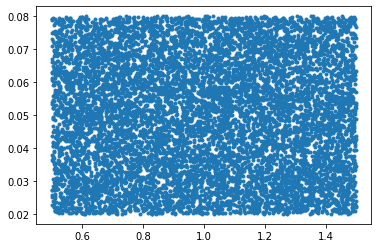

In [16]:
plot_random_params(random_params)   

In [17]:
     
def create_random_env_DC_RL():
    rnd_impact_amplitude, rnd_damping_ratio = random_params()
    return create_env(SimpleModel, x_impact, rnd_impact_amplitude, rnd_damping_ratio)

def create_random_env_just_RL():
    rnd_impact_amplitude, rnd_damping_ratio = random_params()
    return create_env(GeneralSimpleModel, x_impact, rnd_impact_amplitude, rnd_damping_ratio)

In [18]:
n_iterations = 4000

In [19]:
weights_path_DC_RL = f'data/weights_DC_RL_8_{metric}_full_data_small_NN.pth'
scores_path_DC_RL = f'data/scores_DC_RL_8_{metric}_full_data_small_NN.pkl'

cem(agent_DC_RL, test_env_DC_RL, 
    create_random_env_DC_RL, weights_path_DC_RL,
    scores_path_DC_RL, n_iterations)

Episode 200	Average Score: -46465.57	Test Score: -47802.27
Best Average Score: -46465.57	Test Score with Best Average Score: -47802.27
Episode 400	Average Score: -22266.02	Test Score: -16911.79
Best Average Score: -22266.02	Test Score with Best Average Score: -16911.79
Episode 600	Average Score: -7389.48	Test Score: -2008.27
Best Average Score: -7389.48	Test Score with Best Average Score: -2008.27
Episode 800	Average Score: -3266.45	Test Score: -1665.64
Best Average Score: -3266.45	Test Score with Best Average Score: -1665.64
Episode 1000	Average Score: -4286.60	Test Score: -2168.18
Best Average Score: -3266.45	Test Score with Best Average Score: -1665.64
Episode 1200	Average Score: -2197.52	Test Score: -1078.66
Best Average Score: -2197.52	Test Score with Best Average Score: -1078.66
Episode 1400	Average Score: -2276.68	Test Score: -1258.20
Best Average Score: -2197.52	Test Score with Best Average Score: -1078.66
Episode 1600	Average Score: -1999.07	Test Score: -1169.05
Best Average S

In [20]:
weights_path_just_RL = f'data/weights_just_RL_8_{metric}_full_data_small_NN.pth'
scores_path_just_RL = f'data/scores_just_RL_8_{metric}_full_data_small_NN.pkl'

cem(agent_just_RL, test_env_just_RL,
    create_random_env_just_RL, weights_path_just_RL,
    scores_path_just_RL, n_iterations)

Episode 200	Average Score: -14.70	Test Score: -14.01
Best Average Score: -14.70	Test Score with Best Average Score: -14.01
Episode 400	Average Score: -12.73	Test Score: -12.76
Best Average Score: -12.73	Test Score with Best Average Score: -12.76
Episode 600	Average Score: -12.09	Test Score: -10.93
Best Average Score: -12.09	Test Score with Best Average Score: -10.93
Episode 800	Average Score: -10.98	Test Score: -9.16
Best Average Score: -10.98	Test Score with Best Average Score: -9.16
Episode 1000	Average Score: -9.19	Test Score: -8.27
Best Average Score: -9.19	Test Score with Best Average Score: -8.27
Episode 1200	Average Score: -8.34	Test Score: -7.93
Best Average Score: -8.34	Test Score with Best Average Score: -7.93
Episode 1400	Average Score: -8.24	Test Score: -7.66
Best Average Score: -8.24	Test Score with Best Average Score: -7.66
Episode 1600	Average Score: -7.33	Test Score: -6.44
Best Average Score: -7.33	Test Score with Best Average Score: -6.44
Episode 1800	Average Score: -8

# Analysis

In [21]:
with open(scores_path_DC_RL, 'rb') as f:
    scores_DC_RL = pickle.load(f)

with open(scores_path_just_RL, 'rb') as f:
    scores_just_RL = pickle.load(f)
    
agent_DC_RL.load_state_dict(torch.load(weights_path_DC_RL))
agent_just_RL.load_state_dict(torch.load(weights_path_just_RL))

<All keys matched successfully>

In [22]:
experiment.log_asset(file_data=weights_path_DC_RL, file_name=weights_path_DC_RL)
experiment.log_asset(file_data=weights_path_just_RL, file_name=weights_path_just_RL)

{'web': 'https://www.comet.ml/api/asset/download?assetId=88fb8d5f5cdc4919a754dc009efdfc05&experimentKey=1c6caa0b06cb4023986a4e2ce840ab13',
 'api': 'https://www.comet.ml/api/rest/v1/asset/get-asset?assetId=88fb8d5f5cdc4919a754dc009efdfc05&experimentKey=1c6caa0b06cb4023986a4e2ce840ab13'}

In [23]:
# plot the scores
def score_max_filter(train_scores, test_scores):
    max_train_scores = []
    test_scores_with_max_train_scores = []
    last_max_train_score = -float("inf")
    last_test_score_with_max_train_scores = None
    for train_score, test_score in zip(train_scores, test_scores):
        if train_score >= last_max_train_score:
            max_train_scores.append(train_score)
            test_scores_with_max_train_scores.append(test_score)
            last_max_train_score = train_score
            last_test_score_with_max_train_scores = test_score
        else:
            max_train_scores.append(last_max_train_score)
            test_scores_with_max_train_scores.append(last_test_score_with_max_train_scores)
    return max_train_scores, test_scores_with_max_train_scores

def plot_scores(scores, title="", log_comet_ml=True, y_min=-1, max_scores=False):
    fig = plt.figure()
    if max_scores:
        train, test = score_max_filter(scores["train_average_scores"], scores["test_scores"])
        label_test = "test score with max average train score"
        label_train = "max average train score"
        test, train = test[1:], train[1:]   
        title = 'Scores ' + title + ' (rolling maximum train average score)'
    else: 
        train = scores["train_average_scores"][1:]
        test = scores["test_scores"][1:]
        label_test = "test"
        label_train = "train"
        title = 'Scores ' + title
    plt.plot(test, label=label_test)
    plt.plot(train, label=label_train)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.ylim(top=0, bottom=y_min)
    if log_comet_ml:
        i = 0
        for m_test, m_train in zip(test, train):
            experiment.log_metric(title + " -- " + label_test, m_test, epoch=i)
            experiment.log_metric(title + " -- " + label_train, m_train, epoch=i)
            i += 1
    plt.show()

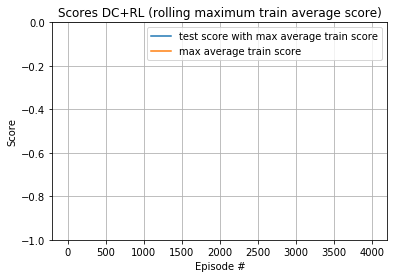

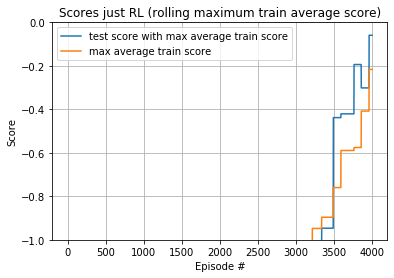

In [24]:
plot_scores(scores_DC_RL, "DC+RL", max_scores=True)
plot_scores(scores_just_RL, "just RL", max_scores=True)

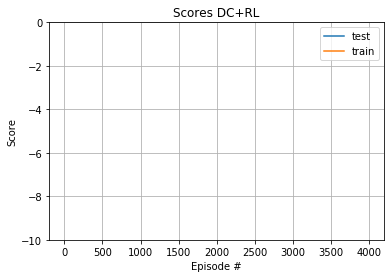

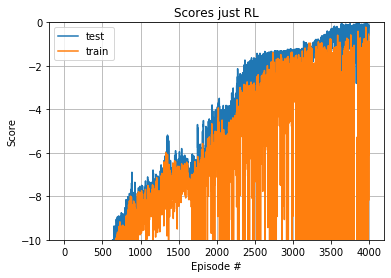

In [25]:
plot_scores(scores_DC_RL, "DC+RL", y_min=-10)
plot_scores(scores_just_RL, "just RL", y_min=-10)

In [26]:
def plot_result(envs, models, labels, title_info=""):
    for env, model, label in zip(envs, models, labels):
        s = env.reset()
        d = False
        points = list(s)[-n_prev:]
        while not d:
            state = torch.from_numpy(s).float().to(device)
            a = list(model(state).numpy())
            s, r, d, _ = env.step(a)
            points.append(s[-1])
        plt.plot(points, label=label)
    plt.plot(env.history, label="true")
    plt.title("CE training" + title_info)
    plt.xlabel("t")
    plt.ylabel("x")
    plt.grid(True)
    plt.legend()
    plt.show()

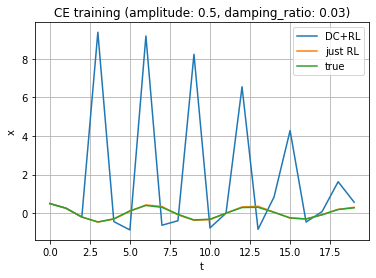

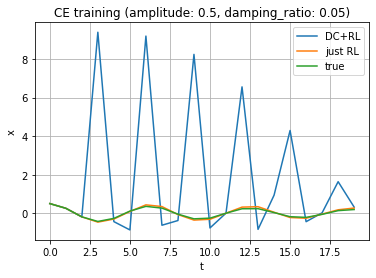

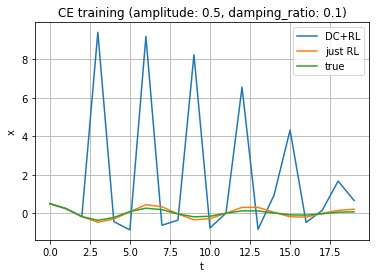

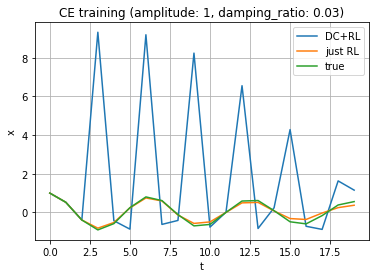

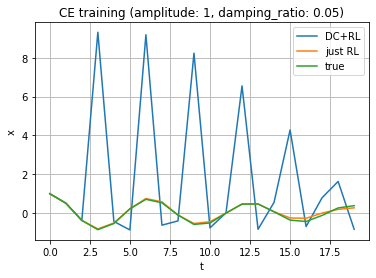

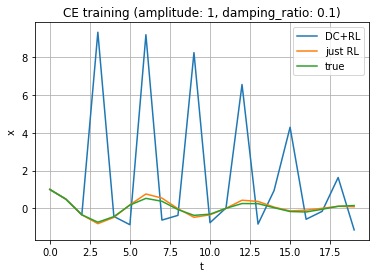

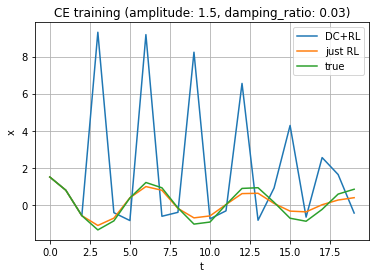

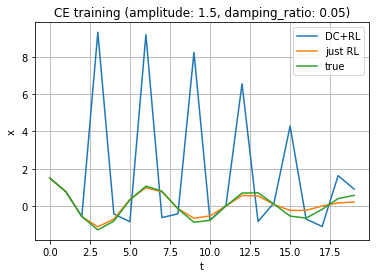

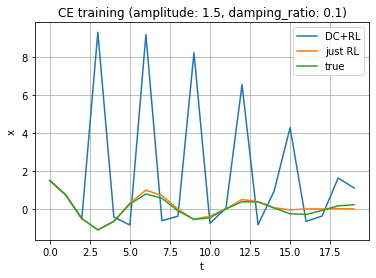

In [27]:
env_models = [SimpleModel, GeneralSimpleModel]
agents = [agent_DC_RL, agent_just_RL]
labels = ["DC+RL", "just RL"]

impact_amplitude_list = [0.5, 1, 1.5]
damping_ratio_list = [0.03, 0.05, 0.1]

for a in impact_amplitude_list:
    for d in damping_ratio_list:
        envs = [
            create_env(env_models[0], x_impact, a, d),
            create_env(env_models[1], x_impact, a, d)
        ]
        info = f" (amplitude: {a}, damping_ratio: {d})"
        plot_result(envs, agents, labels, info)

In [28]:
def hist_pred(env_model, x_impact, impact_amplitude, damping_ratio, agent):
    env = create_env(env_model, x_impact, impact_amplitude, damping_ratio)
    s = env.reset()
    d = False
    predictions = list(s)[-n_prev:]
    while not d:
        state = torch.from_numpy(s).float().to(device)
        a = list(agent(state).numpy())
        s, r, d, _ = env.step(a)
        predictions.append(s[-1])
    return history, predictions

In [29]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

def plot_err(err, env_models, agents, labels, z_max=None, n=10, log_comet_ml=True):
    
    n_plots = len(env_models)
    
#     x = np.linspace(0.2, 1.5, n)
#     y = np.linspace(0.001, 2, n)
    
    x = np.linspace(0.3, 1.7, n)
    y = np.linspace(0.01, 0.09, n)
    
#     x = np.linspace(0.1, 1.7, n)
#     y = np.linspace(0, 0.3, n)
    
    plt.figure(figsize=(14,6))
    title = f'{metric}, {n_steps} steps, n={n}'
    plt.title(title, fontsize=20)
    y_axis = True
    for env_model, agent, label, z in zip(env_models, agents, labels, range(n_plots)):
        Z = np.empty((n, n))
        for i in range(n):
            for j in range(n):
                Z[i, j] = err(env_model, x[i], y[j], agent)
        ax = plt.subplot(1, n_plots, z+1)
        plt.title(label)
        plt.xlabel("impact amplitude")
        plt.pcolor(x, y, Z, vmin=0, vmax=z_max)
        plt.colorbar()
        ax.add_patch(Rectangle((impact_amplitude - 0.5, damping_ratio - 0.03), 1, 0.06, fill=None, alpha=1, color="red"))
        if y_axis:
            plt.ylabel("damping ratio")
        y_axis = False
    if log_comet_ml:
        experiment.log_figure(figure_name=title, figure=plt)
    plt.show()

In [30]:
def err(env_model, a, d, agent):
    hist, pred = hist_pred(env_model, x_impact, a, d, agent)
    if metric == "mse":
        return mse(hist, pred, n_prev)
    elif metric == "mspe":
        return mspe(hist, pred, n_prev)

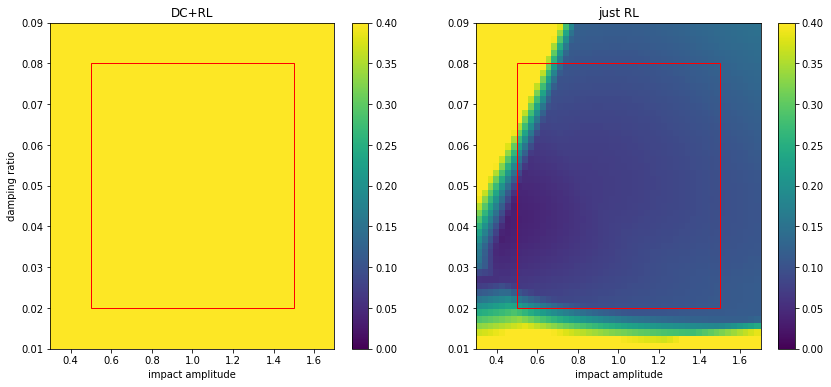

In [31]:
z_max = 0.4
n = 50
plot_err(err, env_models, agents, labels, z_max, n)

In [32]:
experiment.end()

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/bamasa/simple-model/1c6caa0b06cb4023986a4e2ce840ab13
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Scores DC+RL (rolling maximum train average score) -- max average train score [3999]                  : (-150669845.01299253, -674.7671044901768)
COMET INFO:     Scores DC+RL (rolling maximum train average score) -- test score with max average train score [3999]  : (-3411935.7509668493, -1117.0589275828677)
COMET INFO:     Scores DC+RL -- test [3999]                                                                           : (-14873871.395965979, -901.2232927542318)
COMET INFO:     Scores DC+RL -- train [3999]                                                                          : (-178368132.9162609, -674.7671044901768)
COMET INFO:     Scores just RL (rolling maximum train average score) -- max average train score [3999]           